In [1]:
import sys
sys.path.insert(1, r"C:\\Users\\micha\\Documents\\Imperial Courses\\Thesis\\IAEA-thesis")
from Stage1.GAT.GATModel import GraphAttentionNetwork
from Single_Website_Download.Download import main as downloadHTML
import torch
from Stage1.ExtractingGraphs.HTMLtoGraph import html_to_graph, EdgeFeatures
from Stage1.ExtractingGraphs.seleniumDriver import *
from Stage1.ExtractingLabels.swde_label_extraction import *
from Stage2.txtGraphs.textExtractor import extract_chunk_xpaths
from Stage2.txtGraphs.extract_mini_txt_graphs_helper import *
from Stage2.txtGraphs.extract_mini_txt_graphs_helper import main as txtExtractor
from Stage1.tree_helpers import *
from pathlib import Path
from scipy import sparse
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
#Import model
model = GraphAttentionNetwork(in_dim = 114, edge_in_dim = 200, edge_emb_dim = 32, hidden1 = 32, hidden2 = 32, hidden3 = 8, heads = 2)
state_dict = torch.load("../../Stage1/GAT/FULLTRAINEDALLDATAModelf1-75-learning.pt", map_location=torch.device(device))
model.load_state_dict(state_dict)
model.to(device)

GraphAttentionNetwork(
  (tr1): TransformerConv(114, 32, heads=2)
  (ln1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (tr2): TransformerConv(64, 32, heads=1)
  (ln2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (tr3): TransformerConv(32, 8, heads=1)
  (edge_mlp): Sequential(
    (0): Linear(in_features=48, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [10]:
url = ""
htmlFile = "C:\\Users\\micha\\Documents\\Imperial Courses\\Thesis\\IAEA-thesis\\data\\swde\\sourceCode\\sourceCode\\movie\\movie\\movie-allmovie(2000)\\0000.htm"
# url = r"https://www.nucnet.org/news/parliament-resolution-paves-way-for-establishing-nuclear-energy-legislation-6-4-2024"
# htmlFile = Path("C:/Users/micha/Documents/Imperial Courses/Thesis/IAEA-thesis/data/websites/test.html")
# main(url,1,htmlFile)

In [11]:
sorted_label_index, xpaths, txts = txtExtractor(htmlFile, model, safeurl=url) #remove all a's that are diff domain to safeurl
print(sorted_label_index[:10])
print(xpaths[:10])
print(txts[:10])

[[280 279]
 [560 559]
 [561 559]
 [301 302]
 [387 386]
 [560 561]
 [402 403]
 [559 562]
 [560 562]
 [559 563]]
[['/html/body/div/div[3]/table/tbody/tr/td[1]/table/tbody/tr[2]/td/table/tbody/tr/td[2]/div/table[3]/tbody/tr[2]/td[2]', '/html/body/div/div[3]/table/tbody/tr/td[1]/table/tbody/tr[2]/td/table/tbody/tr/td[2]/div/table[3]/tbody/tr[2]/td[1]'], ['/html/body/div/div[3]/table/tbody/tr/td[1]/table/tbody/tr[2]/td/table/tbody/tr/td[1]/table[2]/tbody/tr[11]/td/table/tbody/tr[3]/td/div/ul/li[2]', '/html/body/div/div[3]/table/tbody/tr/td[1]/table/tbody/tr[2]/td/table/tbody/tr/td[1]/table[2]/tbody/tr[11]/td/table/tbody/tr[3]/td/div/ul/li[1]'], ['/html/body/div/div[3]/table/tbody/tr/td[1]/table/tbody/tr[2]/td/table/tbody/tr/td[1]/table[2]/tbody/tr[11]/td/table/tbody/tr[3]/td/div/ul/li[3]', '/html/body/div/div[3]/table/tbody/tr/td[1]/table/tbody/tr[2]/td/table/tbody/tr/td[1]/table[2]/tbody/tr[11]/td/table/tbody/tr[3]/td/div/ul/li[1]'], ['/html/body/div/div[3]/table/tbody/tr/td[1]/table/tbody

In [12]:
groundTruthFP = htmlFile.replace("\\swde\\sourceCode\\sourceCode", "\\swde_HTMLgraphsOLD").replace(".htm", "\\label_index.npy")
groundT = np.load(groundTruthFP)

In [6]:
def top_k_hits(predictions: np.ndarray,
               ground_truth: np.ndarray,
               k: int) -> np.ndarray:
    p = np.asarray(predictions)
    g = np.asarray(ground_truth)
    if p.ndim != 2 or p.shape[1] != 2 or g.ndim != 2 or g.shape[1] != 2: raise ValueError("predictions and ground_truth must be 2D arrays of shape (N, 2).")

    # --- Build adjacency: node -> list of prediction row indices (in rank order) ---
    # O(P) pass; avoids O(P * |V|) masking.
    adj = defaultdict(list)
    for idx, (u, v) in enumerate(p):
        adj[u].append(idx)
        adj[v].append(idx)

    # Only care about nodes that appear in ground truth
    nodes_gt = np.unique(g)

    # Mark predicted rows that are within top-k for any relevant node
    selected_rows = np.zeros(len(p), dtype=bool)
    for u in nodes_gt:
        rows = adj.get(u)
        if rows:
            # rows already in rank order; take first k
            selected_rows[rows[:k]] = True

    # --- Match (undirected) ground-truth edges against selected predicted edges ---
    # Canonicalize by sorting each pair.
    p_sel_sorted = np.sort(p[selected_rows], axis=1)
    gTuple = [tuple(entry) for entry in g]

    gMask = np.array([False]*len(g))
    for entry in p_sel_sorted:
        if tuple(entry) in gTuple:
            gMask[gTuple.index(tuple(entry))] = True

    return g[gMask], g[~gMask]

hits, misses = top_k_hits(sorted_label_index, groundT, 5)
print(len(hits), len(misses))
mask = np.array([entry in hits for entry in sorted_label_index])
txts = np.array(txts)
print(txts[mask])


74 1738
[['Is related to:'
  'The War Zone\xa0 \n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t(1999, Tim Roth)']
 ['accident' 'addict']
 ['accident' 'drugs']
 ...
 ['» In the Spotlight' 'Meditative']
 ['» In the Spotlight' 'Fathers and Daughters']
 ['» In the Spotlight' 'Brief Nudity']]


In [14]:
jsonContent = load_json_of_swde_file(htmlFile, "../..")
htmlFilepth = Path(htmlFile)
txtPairs = list(iterate_pairs(jsonContent, htmlFilepth.name))
print(len(txtPairs))

def top_k_hits_txt(txtPairs, candidateTxtpairs, k, dualDirection=True):
    """
    Checks if key, value edge in txtPairs appears in the top k (w.r.t key) of candidateTxtPairs"""
    found = []
    for gttxt1, gttxt2 in txtPairs:
        gttxt1, gttxt2 = normalise_text(gttxt1), normalise_text(gttxt2)

        # This checks if gttxt1 - gttxt2 is in gttxt1's top k
        i = 0
        for candidatetxt1, candidatetxt2 in candidateTxtpairs:
            if i >= k:
                break

            candidatetxt1, candidatetxt2 = normalise_text(candidatetxt1), normalise_text(candidatetxt2)
            if gttxt1 in candidatetxt1 or gttxt1 in candidatetxt2:
                i += 1
                if gttxt1 in candidatetxt1 and gttxt2 in candidatetxt2:
                    found.append([[gttxt1, gttxt2], i])
                    break
                elif gttxt2 in candidatetxt1 and gttxt1 in candidatetxt2:
                    found.append([[gttxt1, gttxt2], i])
                    break
        
        if dualDirection:
            # This checks if gttxt1 - gttxt2 is in gttxt2's top k
            j=0
            for candidatetxt1, candidatetxt2 in candidateTxtpairs:
                if j >= k:
                    break

                candidatetxt1, candidatetxt2 = normalise_text(candidatetxt1), normalise_text(candidatetxt2)
                if gttxt2 in candidatetxt1 or gttxt2 in candidatetxt2:
                    j += 1
                    if gttxt1 in candidatetxt1 and gttxt2 in candidatetxt2:
                        found.append([[gttxt2, gttxt1], j])
                        break
                    elif gttxt2 in candidatetxt1 and gttxt1 in candidatetxt2:
                        found.append([[gttxt2, gttxt1], j])
                        break

    return found

hitstxt = top_k_hits_txt(txtPairs, txts, 1, False)
print(len(hitstxt))
hitstxt


61
17


[[['amgworkid', 'v155010'], 1],
 [['attributes', 'highproductionvalues'], 1],
 [['cinematicprocess', 'panavision'], 1],
 [['director', 'atomegoyan'], 1],
 [['flags', 'sexualsituations'], 1],
 [['genres', 'drama'], 1],
 [['keywords', 'addict'], 1],
 [['mpaarating', 'r'], 1],
 [['mpaareasons', 'forsexualityandsomelanguage'], 1],
 [['moods', 'inaminorkey'], 1],
 [['otherrelatedworks', 'isrelatedto'], 1],
 [['isrelatedto', 'thewarzone'], 1],
 [['producedby', 'allianceatlantiscommunications'], 1],
 [['setin', 'britishcolumbiacanada'], 1],
 [['themes', 'fathersanddaughters'], 1],
 [['tones', 'bleak'], 1],
 [['types', 'psychologicaldrama'], 1]]

200
200
200
200
200
200
400
400
400
400
400
400
600
600
600
600
600
600
800
800
800
800
800
800
1000
1000
1000
1000
1000
1000
1200
1200
1200
1200
1200
1200
1400
1400
1400
1400
1400
1400
1600
1600
1600
1600
1600
1600
1800
1800
1800
1800
1800
1800
2000
2000
2000
2000
2000
2000


C:\Users\micha\AppData\Local\Temp\ipykernel_92248\2266197296.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(distributions, labels=[str(k) for k in ks], showmeans=True)


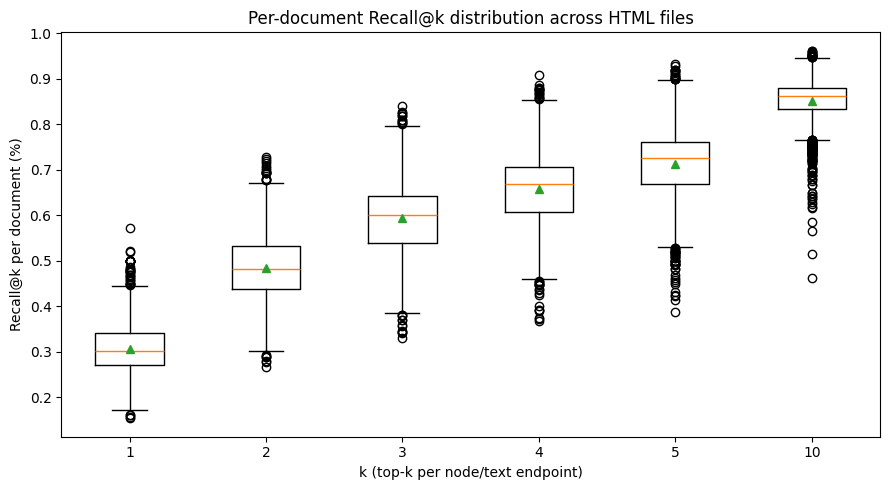

In [21]:
SRC_FOLDER1 = Path("../../data/swde/sourceCode/sourceCode/movie/movie/movie-allmovie(2000)")

ks = [1,2,3,4,5,10]
distributions = [[] for _ in ks]

html_files = list(SRC_FOLDER1.rglob("*.htm"))
jsonContent = load_json_of_swde_file(html_files[0].__str__(), "../..")

for htmlFile in html_files:
    _,_,txts = txtExtractor(htmlFile, model, alreadyConvertedToGraph=htmlFile.__str__().replace("\\swde\\sourceCode\\sourceCode", "\\swde_HTMLgraphsOLD").replace(".htm", ""))
    txtPairs = list(iterate_pairs(jsonContent, htmlFile.name))
    hitstxt = top_k_hits_txt(txtPairs, txts, max(ks))

    for k_idx, k in enumerate(ks):
        specifichitstxt = [hit for hit in hitstxt if hit[1] <= k]
        distributions[k_idx].append(len(specifichitstxt)/(2*len(txtPairs)))

        if len(distributions[0]) % 200 == 0 and k_idx == 0:
            print(len(distributions[0]))

plt.figure(figsize=(9, 5))
plt.boxplot(distributions, labels=[str(k) for k in ks], showmeans=True)
plt.xlabel("k (top-k per node/text endpoint)")
plt.ylabel("Recall@k per document (%)")
plt.title("Per-document Recall@k distribution across HTML files")
plt.tight_layout()
plt.show()

In [47]:
model = GraphAttentionNetwork(in_dim = 119, edge_in_dim = 210, edge_emb_dim = 32, hidden1 = 32, hidden2 = 32, hidden3 = 8, heads = 2)
state_dict = torch.load("../../Stage1/GAT/LONG80EPOCH-75f1-newlabelnotitle.pt", map_location=torch.device(device))
model.load_state_dict(state_dict, strict=False)
model.to(device)

url = "https://www.nfl.com/teams/"
htmlFile = Path("C:/Users/micha/Documents/Imperial Courses/Thesis/IAEA-thesis/data/websites/test.html")
downloadHTML(url,1,htmlFile)

REMOVE_DUPES=True
sorted_label_index, xpaths, txts, probs = main(htmlFile, model, remove_dupes=REMOVE_DUPES)
normtxt = []
for a, b in txts:
    normtxt.append([normalise_text(a), normalise_text(b)])
txts = np.array(normtxt)
#mask = keepTopKMask(txts, 1)
mask = filterTextMask(txts, "afcteams", True)#13karrizabalaga
probs = np.array(probs)
print(txts[mask][:20])
print(probs[mask][:20])
print(len(txts))

Saved https://www.nfl.com/teams/ → C:\Users\micha\Documents\Imperial Courses\Thesis\IAEA-thesis\data\websites\test.html
Page limit hit
[['baltimoreravens' 'afcteams']
 ['buffalobills' 'afcteams']
 ['cincinnatibengals' 'afcteams']
 ['afcteams' 'nfcteams']
 ['clevelandbrowns' 'afcteams']
 ['denverbroncos' 'afcteams']
 ['afcteams' 'houstontexans']
 ['afcteams' 'indianapoliscolts']
 ['afcteams' 'jacksonvillejaguars']
 ['afcteams' 'kansascitychiefs']
 ['afcteams' 'lasvegasraiders']
 ['afcteams' 'losangeleschargers']
 ['afcteams' 'miamidolphins']
 ['afcteams' 'newenglandpatriots']
 ['afcteams' 'newyorkjets']
 ['afcteams' 'pittsburghsteelers']
 ['afcteams' 'viewprofile']
 ['viewprofile' 'afcteams']
 ['afcteams' 'tennesseetitans']
 ['afcteams' 'viewprofile']]
[0.713438   0.7133862  0.6913137  0.66864836 0.66811216 0.64560986
 0.6218092  0.60598874 0.58826977 0.5731219  0.55312467 0.5336705
 0.504207   0.4725826  0.4407091  0.40441707 0.3746347  0.36975446
 0.36859497 0.3573319 ]
4982


In [ ]:
def disparity_backbone_directed(P: np.ndarray, alpha: float = 0.05, rule: str = "or", keep_self_loops: bool = False) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Disparity filter (Serrano et al., 2009) for a directed weighted graph.
    rule = "or" | "and" | "out" | "in"
    This filters out only the strongest connections. If all the probabilities for an edge are of the same order of magnitude, most will not survive. This filters only those nodes that have a few very strong edges
    """
    W = np.asarray(P, dtype=float)
    W = W.copy()
    if np.any(W < 0):
        raise ValueError("P must be non-negative.")
    if not keep_self_loops:
        np.fill_diagonal(W, 0.0)

    # positive-edge mask
    M = W > 0

    # ---------- OUTGOING side (source-node normalization) ----------
    s_out = W.sum(axis=1, keepdims=True)                          # (N,1)
    p_out = np.divide(W, s_out, out=np.zeros_like(W), where=s_out > 0)

    k_out = M.sum(axis=1, keepdims=True)                          # (N,1)
    exp_out = np.maximum(k_out - 1, 1)                            # avoid 0
    alpha_out = np.power(1.0 - p_out, exp_out, where=(p_out > 0), out=np.ones_like(W))

    # For rows with exactly one outgoing edge, force α_out = 0 on that edge
    rows_k1 = np.where((k_out.ravel() == 1))[0]
    for r in rows_k1:
        alpha_out[r, M[r]] = 0.0

    # ---------- INCOMING side (target-node normalization) ----------
    s_in = W.sum(axis=0, keepdims=True)                           # (1,N)
    p_in = np.divide(W, s_in, out=np.zeros_like(W), where=s_in > 0)

    k_in = M.sum(axis=0, keepdims=True)                           # (1,N)
    exp_in = np.maximum(k_in - 1, 1)
    alpha_in = np.power(1.0 - p_in, exp_in, where=(p_in > 0), out=np.ones_like(W))

    cols_k1 = np.where((k_in.ravel() == 1))[0]
    for c in cols_k1:
        alpha_in[M[:, c], c] = 0.0

    # ---------- keep mask by rule ----------
    keep_out = (alpha_out < alpha) & M
    keep_in  = (alpha_in  < alpha) & M

    if rule == "or":
        keep = keep_out | keep_in
    elif rule == "and":
        keep = keep_out & keep_in
    elif rule == "out":
        keep = keep_out
    elif rule == "in":
        keep = keep_in
    else:
        raise ValueError("rule must be one of {'or','and','out','in'}")

    if not keep_self_loops:
        np.fill_diagonal(keep, False)

    # ---------- edge list ----------
    ii, jj = np.nonzero(keep)
    edges = np.column_stack((ii, jj))
    weights = W[keep]

    return edges, weights, keep

In [51]:
# Step 1: find unique node labels
unique_nodes = sorted(set(sum(txts.tolist(), [])))  # flatten list + deduplicate + sort

# Step 2: map each label to an index
node_to_idx = {node: i for i, node in enumerate(unique_nodes)}
idx_to_node = {i: node for i, node in enumerate(unique_nodes)}
print("Mapping:", node_to_idx)

# Step 3: initialize probability matrix
n = len(unique_nodes)
P = np.zeros((n, n))

# Step 4: fill in probabilities
for (u, v), p in zip(txts, probs):
    i, j = node_to_idx[u], node_to_idx[v]
    P[i, j] = p
    if REMOVE_DUPES:
        P[j, i] = p

edges, weights, keep = disparity_backbone_directed(P, 0.05, "out")

i = node_to_idx['afcteams']
nodesToPull = [(pair[0], weight) for pair, weight in zip(edges, weights) if pair[1]==i]   #rule = out
#nodesToPull = [(pair[0], weight) for pair, weight in zip(edges, weights) if pair[1]==i]   #rule = in

nodesToPull_sorted = sorted(nodesToPull, key=lambda x: x[1], reverse=True)

for idx in nodesToPull_sorted:
    print(idx_to_node[idx[0]])

Mapping: {'afcteams': 0, 'arizonacardinals': 1, 'atlantafalcons': 2, 'baltimoreravens': 3, 'buffalobills': 4, 'carolinapanthers': 5, 'chicagobears': 6, 'cincinnatibengals': 7, 'clevelandbrowns': 8, 'dallascowboys': 9, 'denverbroncos': 10, 'detroitlions': 11, 'greenbaypackers': 12, 'houstontexans': 13, 'indianapoliscolts': 14, 'jacksonvillejaguars': 15, 'kansascitychiefs': 16, 'lasvegasraiders': 17, 'losangeleschargers': 18, 'losangelesrams': 19, 'miamidolphins': 20, 'minnesotavikings': 21, 'newenglandpatriots': 22, 'neworleanssaints': 23, 'newyorkgiants': 24, 'newyorkjets': 25, 'nfcteams': 26, 'philadelphiaeagles': 27, 'pittsburghsteelers': 28, 'sanfrancisco49ers': 29, 'seattleseahawks': 30, 'skiptomaincontent': 31, 'tampabaybuccaneers': 32, 'tennesseetitans': 33, 'thebrowseryouareusingisnolongersupportedonthissiteitishighlyrecommendedthatyouusethelatestversionsofasupportedbrowserinordertoreceiveanoptimalviewingexperiencethefollowingbrowsersaresupportedchromeedgev80andlaterfirefoxandsa

1) see how many external links I am picking up, if its an acceptable amount, dw about it
filter out links in html that point to external webpages

2) compare this to just putting it all into an llm. make this a prompting model